In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

def getMatchingPoints(kp1, kp2, des1, des2, thr = 0):

    def computeDist(des1, des2):
        return np.linalg.norm(des1 - des2)

    numKp1 = len(kp1)
    numKp2 = len(kp2)

    dist = []
    for i in range(numKp1):
        dTemp = []
        for j in range(numKp2):
            d = computeDist(des1[i, :], des2[j, :])
            dTemp.append((d, i, j))
            
        sortedA = sorted(dTemp, key=itemgetter(0))[0:2]
        if((thr != 0 and sortedA[0][0] <= thr) or thr == 0):
            dist.append(sortedA)

        if(i%100 == 0):
            print(i, end=" ", flush=True)
    if(thr == 0):
        sDist = sorted(dist, key=lambda x: x[0][0])[0:100]
        return np.array(sDist)
    else:
        return np.array(dist)

In [2]:
left = cv2.imread("./givenImage/left_uttower.JPG")
le = left
leftG = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)

right = cv2.imread("./givenImage/right_uttower.JPG")
rightG = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
ri = right

sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(leftG, None)
kp2, des2 = sift.detectAndCompute(rightG, None)

print(np.array(kp1).shape)

(5317,)


In [3]:
import time
tic = time.time()
matchedPlt = getMatchingPoints(kp1, kp2, des1, des2)
toc = time.time()

print("Time taken = " + str(toc - tic))
print(matchedPlt.shape)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 Time taken = 269.8204369544983
(100, 2, 3)


In [4]:
good = []
for m1, m2 in matchedPlt:
    if(m1[0] < 0.3*m2[0]):
        good.append(m1)

good = np.array(good)
print(good.shape)

(67, 3)


In [5]:
mpL = []
mpR = []
imgL = left.copy()
imgR = right.copy()
for _, i, j in good:
    mpL.append(kp1[int(i)])
    mpR.append(kp2[int(j)])
    
    a, b = kp1[int(i)].pt
    cv2.circle(imgL, (int(a), int(b)), 2, 255, -1)
    a, b = kp2[int(j)].pt
    cv2.circle(imgR, (int(a), int(b)), 2, 255, -1)
#cv2.circle(corner_img,(x+m_at[1],y+m_at[0]),2,255,-1)

print(np.array(mpL).shape, np.array(mpR).shape)

#imgL = cv2.drawKeypoints(left, mpL, imgL)
#imgR = cv2.drawKeypoints(right, mpR, imgR)

cv2.imwrite("LeftMatchingPoints.jpg", imgL)
cv2.imwrite("RightMatchingPoints.jpg", imgR)

(67,) (67,)


True

In [6]:
hA, wA = left.shape[:2]
hB, wB = right.shape[:2]

vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
vis[0:hA, 0:wA] = left
vis[0:hB, wA:] = right

for i in range(len(mpL)):
    ptA = (int(mpL[i].pt[0]), int(mpL[i].pt[1]))
    ptB = (int(mpR[i].pt[0]) + wA, int(mpR[i].pt[1]))
    cv2.line(vis, ptA, ptB, (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255)), 2)

cv2.imwrite("Matchings.jpg", vis)

True

In [8]:
def getHomography(P1, P2):
    
    def getA(X, X1):
        numPt = 4
        A = [] #np.zeros((numPt*2, 9))
        for r in range(0, numPt):
            x, y = X[r] # (u, v)
            u, v = X1[r] # (u', v')
            
            A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
            A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])        
        return A
            
    ind = np.random.randint(low = 0, high = len(P1), size=4)
    #print(ind)
    XL = [P1[i].pt for i in ind] # x
    XR = [P2[i].pt for i in ind] # x'
    
    A = getA(XL, XR)
    u, s, v = np.linalg.svd(A)
    L = v[-1,:] / v[-1,-1]
    h = L.reshape(3, 3)#np.transpose(np.reshape(v[:, v.shape[1]-1], (3,3)))
    
    #print(h)
    return h

In [9]:
# RANSAC
def getNumInliers(H, P1, P2, thr = 100.0):
    
    def getDist(x, y):
        return np.linalg.norm(x - y)
    
    inliers = 0
    sum_dist = 0
    for i in range(len(mpL)):
        a, b = P1[i].pt
        y = H.dot(np.reshape(np.array([a, b, 1]), (3,1)))
        
        a1, b1 = P2[i].pt;
        y1 = np.reshape(np.array([a1, b1, 1]), (3, 1))

        #print(getDist(y, y1))
        if(getDist(y, y1) <= thr):
            inliers += 1
            sum_dist += getDist(y, y1)
    return inliers,sum_dist
        
N = 10
thr = 150
H = []
initialIn = 0
avg = 0
for itr in range(N):
    HTemp = getHomography(mpR, mpL)
    inliers,residuals  = getNumInliers(HTemp, mpR, mpL, thr)
    #print(inliers)
    if(initialIn < inliers):
        initialIn = inliers
        avg = residuals
        
        H = HTemp
    #print("------------------------------------------------------------------")

print(H)
print(initialIn)
print(avg/initialIn)

[[  7.53242036e-01   1.25711366e-01   4.36142144e+02]
 [ -1.50379193e-01   9.70468376e-01   6.85947921e+01]
 [ -2.43837871e-04   5.73042427e-05   1.00000000e+00]]
67
62.2405766961


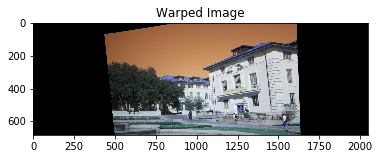

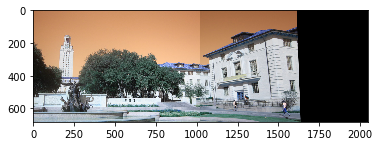

In [10]:
warp = cv2.warpPerspective(right, H, (right.shape[1] + left.shape[1], right.shape[0]))
plt.imshow(warp),plt.title('Warped Image')
plt.show()
plt.figure()
warp[0:left.shape[0], 0:left.shape[1]] = left
cv2.imwrite('resultant.jpg',warp)
plt.imshow(warp)
plt.show()


In [11]:
def Blend(thr1, thr2, warp, left, window = 3):
    temp = warp[0:left.shape[0],left.shape[1]:warp.shape[1]]
    temp1 = temp[0:left.shape[0],window:temp.shape[1]]
    temp2 = temp[0:left.shape[0],0:window]
    blend = cv2.addWeighted(left[0:left.shape[0],left.shape[1]-window:left.shape[1]], thr1, temp2, thr1, 0)
    blend1 = cv2.addWeighted(temp1, thr2, temp1, thr2, 0)#0.595
    blend2 = np.concatenate((left[0:left.shape[0],0:left.shape[1]-window], blend), axis=1) 
    return np.concatenate((blend2, blend1), axis=1)
    

True

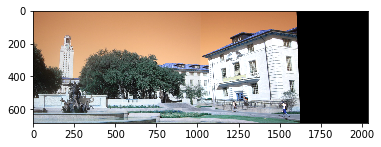

In [12]:
final = Blend(0.55, 0.595, warp, left, 10) #0.595
plt.imshow(final)
cv2.imwrite('resultantAfterBlending.jpg',final)